# 0. Loading data

In [1]:
import pandas as pd

## 0.1. Firstly we load the data

In [2]:
df = pd.read_csv("/home/itsquall/Descargas/T2.csv")
list(df)
print(df.shape)

(78646, 245)


/home/itsquall/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Filtering

## 1.1. Filter rows

The first thing we need to do is to convert strings to datetime since we'll filter rows by date.

In [3]:
df['TimeStemp'] = pd.to_datetime(df['TimeStemp'])

**Then we can apply a filter by date**

**After test some days we decide choose this one since it offers us more different values from sensors**

**In other words: this thay has a lot of activity**

In [4]:
df28 = df[(df['TimeStemp'] > '2016-05-02 06:00:00') & (df['TimeStemp'] <= '2016-05-02 23:59:59')]
print(df28.shape)

(3144, 245)


## 1.2. Filter columns

We'll get only the MEAN columns of the next sensors:

- Accelerometer: Give us info about the mobile's 3D position taking into account the gravity.
- Gyroscope: Allow us to know if mobile is being manipulated
- LinearAcceleration: Taking it into account we can know if mobile is being transported.

In [5]:
df28mean = df28.filter(regex='(AccelerometerStat|GyroscopeStat|LinearAcceleration).*_MEAN$', axis=1)
list(df28mean)

['AccelerometerStat_x_MEAN',
 'AccelerometerStat_y_MEAN',
 'AccelerometerStat_z_MEAN',
 'GyroscopeStat_x_MEAN',
 'GyroscopeStat_y_MEAN',
 'GyroscopeStat_z_MEAN',
 'LinearAcceleration_x_MEAN',
 'LinearAcceleration_y_MEAN',
 'LinearAcceleration_z_MEAN']

Drop null values too

In [6]:
df28mean = df28mean.dropna()
print(df28mean.shape)

(3144, 9)


# 2. Principal Component Analysis
## 2.1. Scalation

In [7]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
datanorm = scaler.fit_transform(df28mean)

## 2.2. Modelling (PCA)

In [8]:
from sklearn.decomposition import PCA

n_components = 3
estimator = PCA(n_components)
X_pca = estimator.fit_transform(datanorm)

## 2.3. Plotting (PCA)

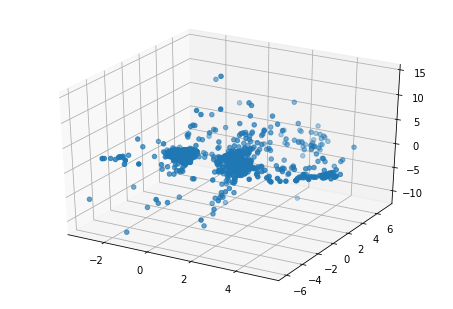

In [20]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
x = X_pca[:,0]
y = X_pca[:,1]
z = X_pca[:,2]
ax.scatter(x,y,z)
plt.show()

# 3. Clustering

## 3.1. Using KMeans

In [10]:
from sklearn.cluster import KMeans
from sklearn import metrics

iterations = 10
max_iter = 300 
tol = 1e-04 
random_state = 0
init = "random"

**We need to search the optimal k**

In [11]:
distortions = []
silhouettes = []

for k in range(2, 25):
    km = KMeans(k, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(X_pca)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(X_pca, labels))

**Distorsions**

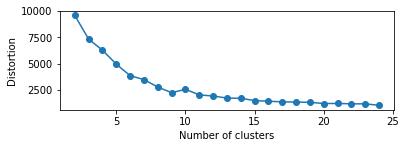

In [12]:
plt.subplot(211)
plt.plot(range(2,25), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

**Silhouettes**

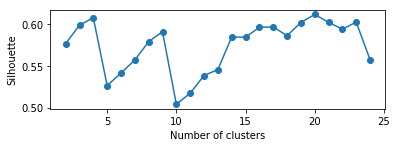

In [13]:
plt.subplot(212)
plt.plot(range(2,25), silhouettes , marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

In [14]:
k = 9
km = KMeans(k, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
labels = km.fit_predict(X_pca)

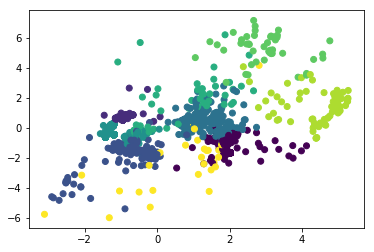

In [15]:
x = X_pca[:,0]
y = X_pca[:,1]
plt.scatter(x,y, c = labels)

## 3.2. Plotting centroids

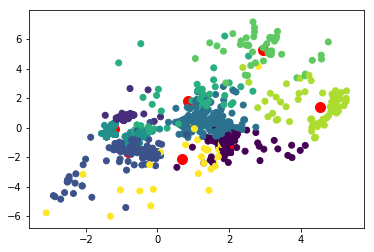

In [16]:
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='red',s=100)
plt.scatter(x,y, c = labels)
plt.show()

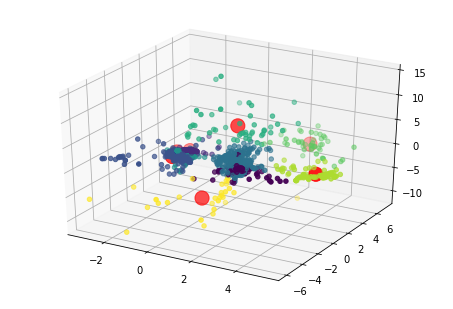

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
x = X_pca[:,0]
y = X_pca[:,1]
z = X_pca[:,2]
ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], km.cluster_centers_[:,2], c='red',s=200)
ax.scatter(x,y,z, c = labels)
plt.show()

## 3.3. Creating CSV to analyze the results

In [18]:
df28mean['clusters'] = labels
df28mean['Date'] = df28['TimeStemp']

In [28]:
import os

directory = "../data/processed"

if not os.path.exists(directory):
    os.makedirs(directory)
    
df28mean.to_csv(directory + "/clusters.csv")